In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

import torch
import torch.nn as nn
import torch.optim as optim

from skorch import NeuralNetBinaryClassifier


In [2]:
data = pd.read_csv('../Data/Final Dataset.csv')
data

/var/folders/5r/dp58bhsd7wvbt6d73cxcyj840000gn/T/ipykernel_76104/4063211449.py:1: DtypeWarning: Columns (44) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Data/Final Dataset.csv')


,Season,PlayerId,Player,Position,Team,Conference,Usage Overall,Usage Pass,Usage Rush,Usage FirstDown,...,Team tacklesForLoss,Team thirdDownConversions,Team thirdDowns,Team totalYards,Team turnovers,Stars,Transfer_Portal,PositionId,TeamId,ConferenceId
0,2019,4240710,A.J. Davis,RB,Pittsburgh,ACC,0.1587,0.0525,0.3056,0.1700,...,124,84,211,4946,22,NaN,No,0,0,0
1,2019,4036066,Aaron Mathews,WR,Pittsburgh,ACC,0.0228,0.0394,0.0024,0.0246,...,124,84,211,4946,22,NaN,No,1,0,0
2,2019,4240724,Dontavius Butler-Jenkins,WR,Pittsburgh,ACC,0.0083,0.0150,0.0000,0.0025,...,124,84,211,4946,22,NaN,No,1,0,0
3,2019,4430681,Jared Wayne,WR,Pittsburgh,ACC,0.0207,0.0356,0.0024,0.0320,...,124,84,211,4946,22,NaN,No,1,0,0
4,2019,4373334,John Vardzel,WR,Pittsburgh,ACC,0.0041,0.0075,0.0000,0.0049,...,124,84,211,4946,22,NaN,No,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17346,2023,5077303,Jacob Lane,DE,Washington,PAC12,NaN,NaN,NaN,NaN,...,63,76,174,6931,20,NaN,No,14,57,4
17347,2023,5078420,Leroy Bryant,CB,Washington,PAC12,NaN,NaN,NaN,NaN,...,63,76,174,6931,20,NaN,No,8,57,4
17348,2023,5082671,Tristan Warner,S,Washington,PAC12,NaN,NaN,NaN,NaN,...,63,76,174,6931,20,NaN,No,9,57,4
17349,2023,5082675,Griffin Miller,LB,Washington,PAC12,NaN,NaN,NaN,NaN,...,63,76,174,6931,20,NaN,No,4,57,4


In [3]:
data.columns

Index(['Season', 'PlayerId', 'Player', 'Position', 'Team', 'Conference',
       'Usage Overall', 'Usage Pass', 'Usage Rush', 'Usage FirstDown',
       'Usage SecondDown', 'Usage ThirdDown', 'Usage StandardDowns',
       'Usage PassingDowns', 'ATT', 'AVG', 'CAR', 'COMPLETIONS', 'FGA', 'FGM',
       'FUM', 'INT', 'In 20', 'LONG', 'LOST', 'NO', 'PCT', 'PD', 'PTS',
       'QB HUR', 'REC', 'SACKS', 'SOLO', 'TB', 'TD', 'TFL', 'TOT', 'XPA',
       'XPM', 'YDS', 'YPA', 'YPC', 'YPP', 'YPR', 'Division', 'ExpectedWins',
       'Total Games', 'Total Wins', 'Total Losses', 'Total Ties',
       'ConferenceGames Games', 'ConferenceGames Wins',
       'ConferenceGames Losses', 'ConferenceGames Ties', 'HomeGames Games',
       'HomeGames Wins', 'HomeGames Losses', 'HomeGames Ties',
       'AwayGames Games', 'AwayGames Wins', 'AwayGames Losses',
       'AwayGames Ties', 'Team firstDowns', 'Team fourthDownConversions',
       'Team fourthDowns', 'Team fumblesLost', 'Team fumblesRecovered',
       'Team g

In [4]:
positions = data.Position.unique()
positions

array(['RB', 'WR', 'QB', 'TE', 'LB', 'DB', 'OL', 'DL', 'CB', 'S', 'PK',
       'LS', 'P', 'DT', 'DE', 'FB', 'C', 'OT', 'G', 'NT', 'ATH', 'OLB',
       '?'], dtype=object)

In [5]:
for i,year in enumerate(['2015','2016','2017','2018', '2019','2020', '2021', '2022', '2023']):
    file = pd.read_csv('../Data/Player Recruit Ranking/' + year + '.csv')
    file.rename(columns = {'AthleteId': 'PlayerId', 'Year': 'Class of'}, inplace = True)
    #file.drop(columns = ['Year', 'Rating', 'Ranking'], inplace = True)
    #file.drop(columns = ['Year'], inplace = True)
    data = data.merge(file, on = 'PlayerId', how = 'left', suffixes = [None, '_' + str(i)])

In [6]:
for i in range(0,9):
    data['Stars'] = data['Stars'].combine_first(data['Stars_' + str(i)])
    data.drop(columns = ['Stars_' + str(i)], inplace = True)
for i in range(1,9):
    data['Rating'] = data['Rating'].combine_first(data['Rating_' + str(i)])
    data['Ranking'] = data['Ranking'].combine_first(data['Ranking_' + str(i)])
    data['Class of'] = data['Class of'].combine_first(data['Class of_' + str(i)])
    data.drop(columns = ['Rating_' + str(i)], inplace = True)
    data.drop(columns = ['Ranking_' + str(i)], inplace = True)
    data.drop(columns = ['Class of_' + str(i)], inplace = True)

data['Yr'] = data['Season'] - data['Class of'] + 1
data.drop(columns = ['Class of'], inplace = True)


In [7]:
data.columns[90:]

Index(['Team thirdDownConversions', 'Team thirdDowns', 'Team totalYards',
       'Team turnovers', 'Stars', 'Transfer_Portal', 'PositionId', 'TeamId',
       'ConferenceId', 'Ranking', 'Rating', 'Yr'],
      dtype='object')

In [8]:
data[data['Player'] == 'J.J. McCarthy']


,Season,PlayerId,Player,Position,Team,Conference,Usage Overall,Usage Pass,Usage Rush,Usage FirstDown,...,Team totalYards,Team turnovers,Stars,Transfer_Portal,PositionId,TeamId,ConferenceId,Ranking,Rating,Yr
5627,2021,4433970,J.J. McCarthy,QB,Michigan,Big10,0.0854,0.1457,0.0418,0.0736,...,6203,14,5.0,No,2,27,1,24.0,0.9868,1.0
6523,2022,4433970,J.J. McCarthy,QB,Michigan,Big10,0.4006,0.8534,0.1046,0.3643,...,6422,10,5.0,No,2,27,1,24.0,0.9868,2.0
6793,2023,4433970,J.J. McCarthy,QB,Michigan,Big10,0.4264,0.9229,0.0819,0.3558,...,5741,8,5.0,No,2,27,1,24.0,0.9868,3.0


In [9]:
position_groups = {'OL':['OL', 'NT', 'OT', 'G', 'C','FB'],
                   'TE':['TE'],
                   'QB':['QB'],
                   'RB':['RB'],
                   'WR':['WR'],
                   'DL':['DT', 'DE', 'DL'],
                   'DB':['DB', 'CB', 'S'],
                   'LB':['LB'],
                   'ST':['LS', 'P', 'PK']}

In [10]:
#Separate Data into Position Groups

data_sets = {}
for key in position_groups.keys():
    data_sets[key] = data.copy()[data.copy()['Position'].isin(position_groups[key])]

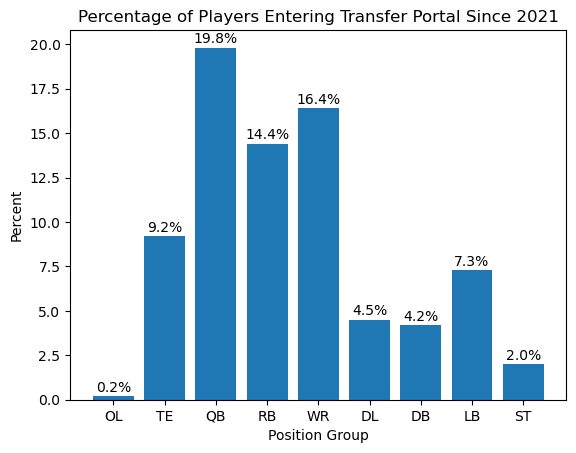

In [11]:
#Visualization showing percentage of players entering the transfer portal from each position group
#Not entirely accurate bc including 2019 data

pcts = []
for key in position_groups.keys():
    t_portal = len(data_sets[key][data_sets[key]['Transfer_Portal'] == 'Yes'])
    total = len(data_sets[key])
    pcts.append(round((t_portal/total) * 100, 1))
    
plt.bar(position_groups.keys(),pcts)

for i in range(len(position_groups.keys())):
    plt.text(list(position_groups.keys())[i], pcts[i] + 0.25, str(pcts[i]) + '%', ha = 'center')
    
plt.xlabel('Position Group')
plt.ylabel('Percent')
plt.title('Percentage of Players Entering Transfer Portal Since 2021')

plt.show()

Testing with RB Data


In [12]:
rb = data_sets['RB'].copy().drop(columns=['Player','Conference','Position','Division', 'Team'])
rb['Transfer_Portal'] = np.where(rb['Transfer_Portal'].values == 'Yes', 1, 0)
print(len(rb[rb['Transfer_Portal'] == 1]))
rb = rb.dropna(subset = ['Yr'])
rb = rb.dropna(subset=['Stars'])
rb = rb.fillna(0)

256


In [13]:
#Here I am testing the effect of filling yr or stars w/0 vs removing yr = 0 or stars = 0 and making sure it's not biasing the data in a bad way
#Check and see if numbers of transfer portal yes and no are drastically effected
#Play with dropping other nans or multiple nans at a time
rb

,Season,PlayerId,Usage Overall,Usage Pass,Usage Rush,Usage FirstDown,Usage SecondDown,Usage ThirdDown,Usage StandardDowns,Usage PassingDowns,...,Team totalYards,Team turnovers,Stars,Transfer_Portal,PositionId,TeamId,ConferenceId,Ranking,Rating,Yr
0,2019,4240710,0.1587,0.0525,0.3056,0.1700,0.202,0.101,0.164,0.142,...,4946,22,4.0,0,0,0,0,303.0,0.8945,3.0
11,2019,4240711,0.0560,0.0075,0.1222,0.0616,0.074,0.019,0.058,0.047,...,4946,22,4.0,0,0,0,0,273.0,0.9000,3.0
14,2019,4568660,0.0685,0.0131,0.1443,0.0788,0.083,0.034,0.088,0.041,...,4946,22,3.0,0,0,0,0,856.0,0.8613,1.0
61,2019,4037221,0.1559,0.0145,0.2881,0.1786,0.168,0.107,0.194,0.101,...,6030,17,3.0,0,0,1,0,931.0,0.8457,4.0
63,2019,4361999,0.0038,0.0000,0.0073,0.0045,0.003,0.004,0.000,0.006,...,6030,17,3.0,0,0,1,0,1129.0,0.8477,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17551,2023,4430810,0.0062,0.0000,0.0152,0.0086,0.003,0.006,0.016,0.000,...,6931,20,4.0,0,0,57,4,125.0,0.9464,4.0
17554,2023,4689338,0.2639,0.0456,0.5833,0.2741,0.298,0.176,0.380,0.152,...,6931,20,3.0,0,0,57,4,441.0,0.8830,4.0
17567,2023,4361095,0.0051,0.0000,0.0126,0.0064,0.003,0.006,0.008,0.000,...,6931,20,3.0,0,0,57,4,525.0,0.8767,6.0
17569,2023,4429186,0.0123,0.0035,0.0253,0.0128,0.010,0.018,0.012,0.011,...,6931,20,4.0,0,0,57,4,287.0,0.9015,4.0


In [14]:
rb.columns

Index(['Season', 'PlayerId', 'Usage Overall', 'Usage Pass', 'Usage Rush',
       'Usage FirstDown', 'Usage SecondDown', 'Usage ThirdDown',
       'Usage StandardDowns', 'Usage PassingDowns', 'ATT', 'AVG', 'CAR',
       'COMPLETIONS', 'FGA', 'FGM', 'FUM', 'INT', 'In 20', 'LONG', 'LOST',
       'NO', 'PCT', 'PD', 'PTS', 'QB HUR', 'REC', 'SACKS', 'SOLO', 'TB', 'TD',
       'TFL', 'TOT', 'XPA', 'XPM', 'YDS', 'YPA', 'YPC', 'YPP', 'YPR',
       'ExpectedWins', 'Total Games', 'Total Wins', 'Total Losses',
       'Total Ties', 'ConferenceGames Games', 'ConferenceGames Wins',
       'ConferenceGames Losses', 'ConferenceGames Ties', 'HomeGames Games',
       'HomeGames Wins', 'HomeGames Losses', 'HomeGames Ties',
       'AwayGames Games', 'AwayGames Wins', 'AwayGames Losses',
       'AwayGames Ties', 'Team firstDowns', 'Team fourthDownConversions',
       'Team fourthDowns', 'Team fumblesLost', 'Team fumblesRecovered',
       'Team games', 'Team interceptionTDs', 'Team interceptionYards',
      

In [15]:

rb['Team_Win_Performance'] = rb['Total Wins'] > rb['ExpectedWins']
rb['Team_Win_Performance'] = rb['Team_Win_Performance'].apply(lambda x: 0 if x == False else 1)
rb['Team_Rush_Yds_Pct'] = rb['Team rushingYards']/ rb['Team totalYards']
rb['Pct_Team_Rush_Yds'] = rb['YDS']/rb['Team rushingYards']
rb['Pct_Team_Rush_Attempts'] = rb['CAR']/rb['Team rushingAttempts']
rb['Pct_Team_Rush_TDs'] = rb['TD']/rb['Team rushingTDs']

rb = rb[['Season','PlayerId','TeamId', 'Yr','Usage Overall', 'Usage Rush', 'Usage StandardDowns', 'Usage FirstDown', 'Usage SecondDown', 'Usage ThirdDown', 'CAR', 'YPC', 'Team_Win_Performance', 'Team_Rush_Yds_Pct', 'Pct_Team_Rush_Yds', 'Pct_Team_Rush_Attempts', 'Pct_Team_Rush_TDs', 'Transfer_Portal', 'Stars', 'Rating', 'Ranking']]
rb.corr()['Transfer_Portal']

Season                    0.035404
PlayerId                  0.001440
TeamId                   -0.012823
Yr                        0.015358
Usage Overall            -0.122575
Usage Rush               -0.117631
Usage StandardDowns      -0.121037
Usage FirstDown          -0.118981
Usage SecondDown         -0.117468
Usage ThirdDown          -0.122760
CAR                      -0.114125
YPC                      -0.046806
Team_Win_Performance      0.009203
Team_Rush_Yds_Pct        -0.026657
Pct_Team_Rush_Yds        -0.113180
Pct_Team_Rush_Attempts   -0.113192
Pct_Team_Rush_TDs        -0.127403
Transfer_Portal           1.000000
Stars                    -0.134918
Rating                    0.002548
Ranking                  -0.005488
Name: Transfer_Portal, dtype: float64

In [16]:

#0 means not improved, 1 means improved, 2 means freshman or did not play previous season
def improve(row, column):
    try: 
        id = int(row['PlayerId'])
        season = int(row['Season'])
        column = column
        imp = float(rb[(rb['PlayerId'] == id) & (rb['Season'] == season)][column]) > float(rb[(rb['PlayerId'] == id) & (rb['Season'] == season-1)][column])
        return(int(imp)) 
    except:
        return 1 
 
    

In [17]:
rb['Usage Ovr Improve'] = rb.apply(lambda x: improve(x, 'Usage Overall'), axis = 1)
rb['Usage Rush Improve'] = rb.apply(lambda x: improve(x, 'Usage Rush'), axis = 1)
rb['Usage Standard Improve'] = rb.apply(lambda x: improve(x, 'Usage StandardDowns'), axis = 1)
rb['Usage First Improve'] = rb.apply(lambda x: improve(x, 'Usage FirstDown'), axis = 1)
rb['Usage Second Improve'] = rb.apply(lambda x: improve(x, 'Usage SecondDown'), axis = 1)
rb['Usage Third Improve'] = rb.apply(lambda x: improve(x, 'Usage ThirdDown'), axis = 1)
rb['CAR Improve'] = rb.apply(lambda x: improve(x, 'CAR'), axis = 1)
rb['YPC Improve'] = rb.apply(lambda x: improve(x, 'YPC'), axis = 1)
rb['Pct Rush Yds Improve'] = rb.apply(lambda x: improve(x, 'Pct_Team_Rush_Yds'), axis = 1)
rb['Pct Rush Att Improve'] = rb.apply(lambda x: improve(x, 'Pct_Team_Rush_Attempts'), axis = 1)
rb['Pct Team Rush TDs Improve'] = rb.apply(lambda x: improve(x, 'Pct_Team_Rush_TDs'), axis = 1)


/var/folders/5r/dp58bhsd7wvbt6d73cxcyj840000gn/T/ipykernel_76104/124721708.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  imp = float(rb[(rb['PlayerId'] == id) & (rb['Season'] == season)][column]) > float(rb[(rb['PlayerId'] == id) & (rb['Season'] == season-1)][column])
/var/folders/5r/dp58bhsd7wvbt6d73cxcyj840000gn/T/ipykernel_76104/451503594.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rb['Usage Ovr Improve'] = rb.apply(lambda x: improve(x, 'Usage Overall'), axis = 1)
/var/folders/5r/dp58bhsd7wvbt6d73cxcyj840000gn/T/ipykernel_76104/124721708.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a Typ

In [18]:
#Get Rid of 2019 Data
rb = rb[rb['Season'] != 2019]
#rb = rb.dropna()
#Most Correlated Columns subset
#rb = rb.loc[:, abs(rb.corr()['Transfer_Portal']) > 0.08]
rb

,Season,PlayerId,TeamId,Yr,Usage Overall,Usage Rush,Usage StandardDowns,Usage FirstDown,Usage SecondDown,Usage ThirdDown,...,Usage Rush Improve,Usage Standard Improve,Usage First Improve,Usage Second Improve,Usage Third Improve,CAR Improve,YPC Improve,Pct Rush Yds Improve,Pct Rush Att Improve,Pct Team Rush TDs Improve
854,2020,4240710,0,4.0,0.0932,0.1635,0.107,0.0983,0.105,0.074,...,0,0,0,0,0,0,1,0,0,0
857,2020,4568658,0,2.0,0.0186,0.0354,0.036,0.0173,0.030,0.006,...,1,1,1,1,1,1,1,1,1,1
862,2020,4429202,0,1.0,0.0398,0.0763,0.026,0.0578,0.041,0.006,...,1,1,1,1,1,1,1,1,1,1
876,2020,4240711,0,4.0,0.0149,0.0300,0.005,0.0260,0.004,0.011,...,0,0,0,0,0,0,0,0,0,1
878,2020,4568660,0,2.0,0.2124,0.3896,0.250,0.2457,0.229,0.131,...,1,1,1,1,1,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17551,2023,4430810,57,4.0,0.0062,0.0152,0.016,0.0086,0.003,0.006,...,0,0,0,0,0,0,0,0,0,0
17554,2023,4689338,57,4.0,0.2639,0.5833,0.380,0.2741,0.298,0.176,...,1,1,1,1,1,1,0,1,1,1
17567,2023,4361095,57,6.0,0.0051,0.0126,0.008,0.0064,0.003,0.006,...,0,0,0,0,0,0,1,0,0,0
17569,2023,4429186,57,4.0,0.0123,0.0253,0.012,0.0128,0.010,0.018,...,0,0,0,0,1,0,0,0,0,0


In [19]:
rb.corr()['Transfer_Portal']

Season                       0.019840
PlayerId                    -0.033179
TeamId                      -0.021421
Yr                           0.055558
Usage Overall               -0.124197
Usage Rush                  -0.117932
Usage StandardDowns         -0.123238
Usage FirstDown             -0.119459
Usage SecondDown            -0.120266
Usage ThirdDown             -0.121754
CAR                         -0.120343
YPC                         -0.045534
Team_Win_Performance        -0.011530
Team_Rush_Yds_Pct           -0.027616
Pct_Team_Rush_Yds           -0.110634
Pct_Team_Rush_Attempts      -0.116538
Pct_Team_Rush_TDs           -0.126010
Transfer_Portal              1.000000
Stars                       -0.143539
Rating                      -0.017416
Ranking                      0.013452
Usage Ovr Improve           -0.141073
Usage Rush Improve          -0.131007
Usage Standard Improve      -0.172074
Usage First Improve         -0.142183
Usage Second Improve        -0.158859
Usage Third 

In [20]:
k_folds = KFold(n_splits=5)
#Unbalanced Data
X = rb.copy().drop(columns = ['Transfer_Portal', 'PlayerId', 'Season'])
y = rb.copy()['Transfer_Portal']





In [21]:
def classifiers(X,y):
    SVM_clf = make_pipeline(StandardScaler(), SVC(gamma='auto', random_state=42))
    forest_clf = make_pipeline(StandardScaler(),RandomForestClassifier(random_state=42))
    gb_clf = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=42))

    SVM_f1 = cross_val_score(SVM_clf, X, y, cv=k_folds, scoring='f1')
    forest_f1 = cross_val_score(forest_clf, X, y, cv=k_folds, scoring='f1')
    gb_f1 = cross_val_score(gb_clf, X, y, cv=k_folds, scoring='f1')

    SVM_pre = cross_val_score(SVM_clf, X, y, cv=k_folds, scoring='precision')
    forest_pre = cross_val_score(forest_clf, X, y, cv=k_folds, scoring='precision')    
    gb_pre = cross_val_score(gb_clf, X, y, cv=k_folds, scoring='precision')
    
    SVM_re = cross_val_score(SVM_clf, X, y, cv=k_folds, scoring='recall')
    forest_re = cross_val_score(forest_clf, X, y, cv=k_folds, scoring='recall')
    gb_re = cross_val_score(gb_clf, X, y, cv=k_folds, scoring='recall')

    print('F1 Scores')
    print('SVM', SVM_f1.mean())
    print('Random Forest',forest_f1.mean())
    print('Gradient Boosting', gb_f1.mean())
    print(' ')
    print('Precision Scores')
    print('SVM',SVM_pre.mean())
    print('Random Forest',forest_pre.mean())
    print('Gradient Boosting', gb_pre.mean())
    print(' ')
    print('Recall Scores')
    print('SVM', SVM_re.mean())
    print('Random Forest',forest_re.mean())
    print('Gradient Boosting', gb_re.mean())

classifiers(X,y)

/Users/yashdave/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yashdave/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yashdave/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yashdave/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classifica

F1 Scores
SVM 0.0
Random Forest 0.1943240093240093
Gradient Boosting 0.2819212387192009
 
Precision Scores
SVM 0.0
Random Forest 0.646984126984127
Gradient Boosting 0.6275210084033613
 
Recall Scores
SVM 0.0
Random Forest 0.11554675716440421
Gradient Boosting 0.20246983408748115


In [69]:
#Balance Data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
balancer_train = SMOTE(random_state = 42, k_neighbors=5)

X_train_b, y_train_b = balancer_train.fit_resample(X_train, y_train)


#Run Classifier Function w/ Balanced Data
classifiers(X_train_b, y_train_b)

F1 Scores
SVM 0.6496509202738551
Random Forest 0.7295638643879441
Gradient Boosting 0.6976921982239764
 
Precision Scores
SVM 0.6297599301615016
Random Forest 0.7061507936507937
Gradient Boosting 0.6912657100445324
 
Recall Scores
SVM 0.7133370300871398
Random Forest 0.7673327699480532
Gradient Boosting 0.7107010006373203


In [70]:
clf_r = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=42)).fit(X_train_b, y_train_b)
clf_s = make_pipeline(StandardScaler(), SVC(gamma='auto')).fit(X_train_b, y_train_b)
clf_gb = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state = 42, n_estimators=110, max_features = 'sqrt')).fit(X_train_b, y_train_b)
clf_dt = make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=42)).fit(X_train_b, y_train_b)

In [71]:
preds = clf_gb.predict(X_test)
print(f1_score(y_test, preds, average = 'binary'))
print(precision_score(y_test, preds, average = 'binary'))
print(recall_score(y_test, preds, average = 'binary'))
print(' ')

preds = clf_r.predict(X_test)
print(f1_score(y_test, preds, average = 'binary'))
print(precision_score(y_test, preds, average = 'binary'))
print(recall_score(y_test, preds, average = 'binary'))
print(' ')

preds = clf_s.predict(X_test)
print(f1_score(y_test, preds, average = 'binary'))
print(precision_score(y_test, preds, average = 'binary'))
print(recall_score(y_test, preds, average = 'binary'))
print(' ')


preds = clf_dt.predict(X_test)
print(f1_score(y_test, preds, average = 'binary'))
print(precision_score(y_test, preds, average = 'binary'))
print(recall_score(y_test, preds, average = 'binary'))

0.5223880597014925
0.5303030303030303
0.5147058823529411
 
0.3966942148760331
0.4528301886792453
0.35294117647058826
 
0.44155844155844154
0.3953488372093023
0.5
 
0.39436619718309857
0.3783783783783784
0.4117647058823529


Deep Learning Test


In [83]:
class DeepLearningClassifier(nn.Module):
    def __init__(self):
        super(DeepLearningClassifier, self).__init__()

        self.linear_relu = nn.Sequential(
            nn.Linear(21,21),
            nn.ReLU(),
            nn.Linear(21,21),
            nn.ReLU(),
            nn.Linear(21,21),
            nn.ReLU(),
            nn.Linear(21,1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.linear_relu(x)

In [85]:
deep_X_train = torch.as_tensor(X_train_b.values, dtype = torch.float32)
deep_y_train = torch.as_tensor(y_train_b.to_numpy(), dtype = torch.float32)

np.random.seed(42)
torch.manual_seed(42)

deep_learning = NeuralNetBinaryClassifier(DeepLearningClassifier, 
                                          criterion = nn.BCELoss, 
                                          optimizer = optim.Adamax, 
                                          lr = 0.0001, 
                                          max_epochs = 1000, 
                                          batch_size = 5,
                                          verbose = 0)
#deep_pre = cross_val_score(deep_learning, deep_X_train, deep_y_train, cv = k_folds, scoring = 'precision')
#deep_re = cross_val_score(deep_learning, deep_X_train, deep_y_train, cv = k_folds, scoring = 'recall')

In [58]:
#print(deep_pre.mean())
#print(deep_re.mean())

In [86]:
deep_learning.fit(deep_X_train, deep_y_train)

<class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=DeepLearningClassifier(
    (linear_relu): Sequential(
      (0): Linear(in_features=21, out_features=21, bias=True)
      (1): ReLU()
      (2): Linear(in_features=21, out_features=21, bias=True)
      (3): ReLU()
      (4): Linear(in_features=21, out_features=21, bias=True)
      (5): ReLU()
      (6): Linear(in_features=21, out_features=1, bias=True)
      (7): Sigmoid()
    )
  ),
)

In [228]:
deep_X_test = torch.as_tensor(X_test.values, dtype = torch.float32)
deep_y_test = torch.as_tensor(y_test.to_numpy(), dtype = torch.float32)

In [229]:
preds = deep_learning.predict(deep_X_test)
print(f1_score(deep_y_test, preds))
print(recall_score(deep_y_test, preds))
print(precision_score(deep_y_test, preds))


0.3374485596707819
0.5774647887323944
0.23837209302325582


In [230]:
#Deep learning and Gradient Boosting Classifier gets better recall compared to other models on the unseen test data

#This might be an ok result for us, since the cost of potentially acting on a player that is falsely identified as a
#transfer risk is low, but the cost of not acting on a player that is correctly identified as a transfer risk is high. 

#Therefore, in our case, recall might be the more important metric to consider.

#We still probably want to get a higher precision than we currently are (aim to get f1 score above 0.5)